# Building Gaussian Process Models in PyMC3

Now that we have a general idea about covariance functions, let's begin by defining one for our first model.

We can use a Matern(5/2) covariance to model our simulated data, and pass this as the `cov_func` argument to the `Marginal` class.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd 
import pymc3 as pm
import seaborn as sns
import theano
import theano.tensor as tt
import matplotlib.pylab as plt
import matplotlib.cm as cmap
import arviz as az
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
sns.set_context('notebook')

In [22]:
with pm.Model() as model:
    
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    
    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    mean = pm.gp.mean.Constant(c=1)
    gp = pm.gp.Marginal(mean_func=mean, cov_func=cov)

### The `.marginal_likelihood` method

The unknown latent function can be analytically integrated out of the product of the GP prior probability with a normal likelihood.  This quantity is called the marginal likelihood. 

$$
p(y \mid x) = \int p(y \mid f, x) \, p(f \mid x) \, df
$$

The log of the marginal likelihood, $p(y \mid x)$, is

$$
\log p(y \mid x) = 
  -\frac{1}{2} (\mathbf{y} - \mathbf{m}_x)^{T} 
               (\mathbf{K}_{xx} + \boldsymbol\Sigma)^{-1} 
               (\mathbf{y} - \mathbf{m}_x)
  - \frac{1}{2}|\mathbf{K}_{xx} + \boldsymbol\Sigma|
  - \frac{n}{2}\log (2 \pi)
$$

$\boldsymbol\Sigma$ is the covariance matrix of the Gaussian noise.  Since the Gaussian noise doesn't need to be white to be conjugate, the `marginal_likelihood` method supports either using a white noise term when a scalar is provided, or a noise covariance function when a covariance function is provided.

The `gp.marginal_likelihood` method implements the quantity given above.

In [23]:
X = x.reshape(-1, 1)

with model:
    
    σ = pm.HalfCauchy("σ", beta=5)
    obs = gp.marginal_likelihood("obs", X=X, y=y, noise=σ)

In [24]:
with model:
    marginal_post = pm.find_MAP()

/Users/cfonnesbeck/anaconda3/envs/bayes_course/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -232.1, ||grad|| = 0.00037013: 100%|██████████| 12/12 [00:00<00:00, 79.44it/s]  


We can collect the results into a pandas dataframe to display

In [25]:
pd.DataFrame({"Parameter": ["ℓ", "η", "σ"], 
              "Value at MAP": [float(marginal_post["ℓ"]), float(marginal_post["η"]), float(marginal_post["σ"])],
              "True value": [ℓ_true, η_true, σ_true]})

,Parameter,Value at MAP,True value
0,ℓ,1.071717,1.0
1,η,3.774687,3.0
2,σ,1.903994,2.0


### The `.conditional` distribution

In addition to fitting the model, we would like to be able to generate predictions. This implies sampling from the posterior predictive distribution, which if you recall is just some linear algebra:

$$\begin{aligned}
m^*(x^*) &= k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}y \\
k^*(x^*) &= k(x^*,x^*)+\sigma^2 - k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}k(x^*,x)
\end{aligned}$$

PyMC3 allows for predictive sampling after the model is fit, using the recorded values of the model parameters to generate samples. The `conditional` method implements the predictive GP above, called with a grid of points over which to generate realizations:

The `.conditional` has an optional flag for `pred_noise`, which defaults to `False`.  When `pred_noise=False`, the `conditional` method produces the predictive distribution for the underlying function represented by the GP.  When `pred_noise=True`, the `conditional` method produces the predictive distribution for the GP plus noise.  

If using an additive GP model, the conditional distribution for individual components can be constructed by setting the optional argument `given`.  

We can define a grid of new values from `x=0` to `x=20`, then add the GP conditional to the model, given the new X values:



In [26]:
X_new = np.linspace(0, 20, 600)[:,None]

with model:
    f_pred = gp.conditional("f_pred", X_new)

We can draw samples from the posterior predictive distribution over the specified grid of values.

In [27]:
with model:
    pred_samples = pm.sample_posterior_predictive([marginal_post], vars=[f_pred], samples=100)

100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


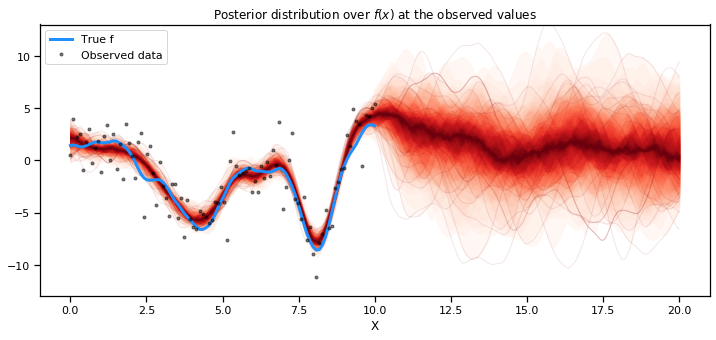

In [28]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], X_new);

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylim([-13,13]);
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

The prediction also matches the results from `gp.Latent` very closely.  What about predicting new data points?  Here we only predicted $f_*$, not $f_*$ + noise, which is what we actually observe.

The `conditional` method of `gp.Marginal` contains the flag `pred_noise` whose default value is `False`.  To draw from the *posterior predictive* distribution, we simply set this flag to `True`. 

In [29]:
with model:
    y_pred = gp.conditional("y_pred", X_new, pred_noise=True)
    y_samples = pm.sample_posterior_predictive([marginal_post], vars=[y_pred], samples=100)

100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


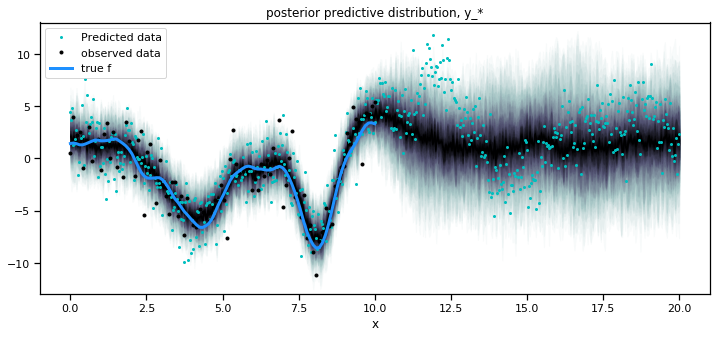

In [30]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# posterior predictive distribution
plot_gp_dist(ax, y_samples["y_pred"], X_new, plot_samples=False, palette="bone_r");

# overlay a scatter of one draw of random points from the 
#   posterior predictive distribution
plt.plot(X_new, y_samples["y_pred"][50, :].T, "co", ms=2, label="Predicted data");

# plot original data and true function
plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f");

plt.xlabel("x"); plt.ylim([-13,13]);
plt.title("posterior predictive distribution, y_*"); plt.legend();

### Real-world example: Spawning salmon

That was contrived data; let's try applying Gaussian processes to a real problem. The plot below shows the relationship between the number of spawning salmon in a particular stream and the number of fry that are recruited into the population in the spring.

We would like to model this relationship, which appears to be non-linear (we have biological knowledge that suggests it should be non-linear too).

![](images/spawn.jpg)

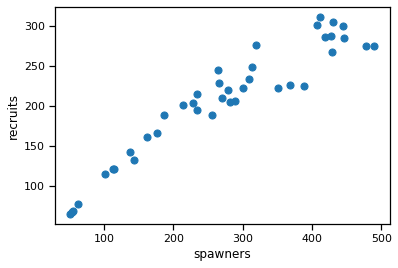

In [31]:
salmon_data = pd.read_table('../data/salmon.txt', sep='\s+', index_col=0)
salmon_data.plot.scatter(x='spawners', y='recruits', s=50);

In [32]:
with pm.Model() as salmon_model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 3)
    η = pm.HalfCauchy('η', 3)
    
    M = pm.gp.mean.Linear(coeffs=(salmon_data.recruits/salmon_data.spawners).mean())
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ) 
    
    σ = pm.HalfCauchy('σ', 1)
    
    recruit_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    recruit_gp.marginal_likelihood('recruits', X=salmon_data.spawners.values.reshape(-1,1), 
                           y=salmon_data.recruits.values, noise=σ)
    

In [33]:
with salmon_model:
    salmon_trace = pm.sample(1000, tune=2000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [σ, η, ρ]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:27<00:00, 219.14draws/s]
The number of effective samples is smaller than 25% for some parameters.


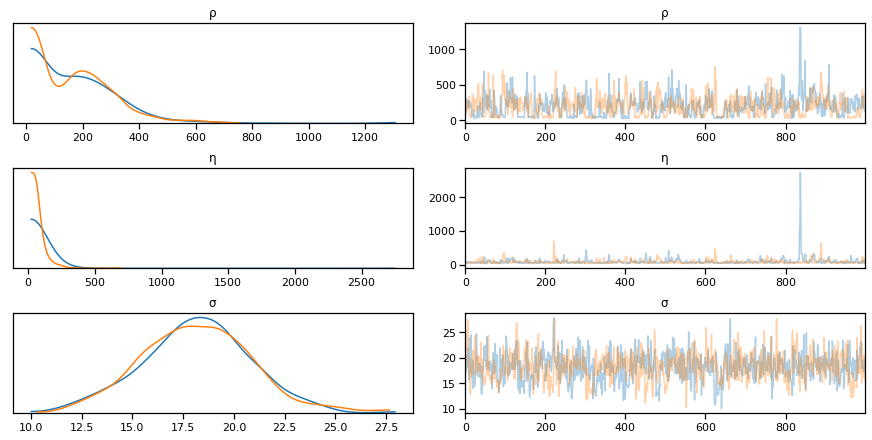

In [34]:
az.plot_trace(salmon_trace, var_names=['ρ', 'η', 'σ']);

In [35]:
X_pred = np.linspace(0, 500, 100).reshape(-1, 1)
with salmon_model:
    salmon_pred = recruit_gp.conditional("salmon_pred", X_pred)
    salmon_samples = pm.sample_posterior_predictive(salmon_trace, vars=[salmon_pred], samples=3, random_seed=42)

100%|██████████| 3/3 [00:00<00:00,  7.72it/s]


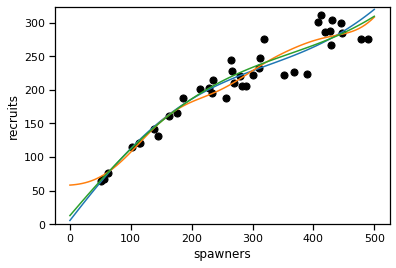

In [36]:
ax = salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50)
ax.set_ylim(0, None)
for x in salmon_samples['salmon_pred']:
    ax.plot(X_pred, x);

### Exercise

We might be interested in what may happen if the population gets very large -- say, 600 or 800 spawners. We can predict this, though it goes well outside the range of data that we have observed. Generate predictions from the posterior predictive distribution (via `conditional`) that covers this range of spawners.

In [37]:
# Write answer here

### Using `.predict`

We can use the `.predict` method to return the mean and variance given a particular `point`.  Since we used `find_MAP` in this example, `predict` returns the same mean and covariance that the distribution of `.conditional` has.  

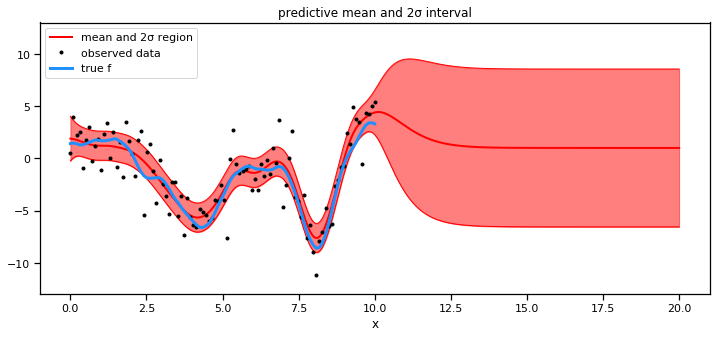

In [38]:
# predict
mu, var = gp.predict(X_new, point=marginal_post, diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 2σ region");
plt.plot(X_new, mu + 2*sd, 'r', lw=1); plt.plot(X_new, mu - 2*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f");

plt.xlabel("x"); plt.ylim([-13,13]);
plt.title("predictive mean and 2σ interval"); plt.legend();

## Latent Variable Implementation

The `gp.Latent` class is a more general implementation of a GP.  It is called "Latent" because the underlying function values are treated as latent variables.  It has a `prior` method, and a `conditional` method.  Given a mean and covariance function, the function $f(x)$ is modeled as,

$$
f(x) \sim \mathcal{GP}(m(x),\, k(x, x')) \,.
$$

## `.prior`

With some data set of finite size, the `prior` method places a multivariate normal prior distribution on the vector of function values, $\mathbf{f}$,

$$
\mathbf{f} \sim \text{MvNormal}(\mathbf{m}_{x},\, \mathbf{K}_{xx}) \,,
$$

where the vector $\mathbf{m}$ and the matrix $\mathbf{K}_{xx}$ are the mean vector and covariance matrix evaluated over the inputs $x$.  

By default, PyMC3 reparameterizes the prior on `f` under the hood by rotating it with the Cholesky factor of its covariance matrix.  This helps to reduce covariances in the posterior of the transformed random variable, `v`.  The reparameterized model is,

$$
\begin{aligned}
  \mathbf{v} \sim \text{N}(0, 1)& \\
  \mathbf{L} = \text{Cholesky}(\mathbf{K}_{xx})& \\
  \mathbf{f} = \mathbf{m}_{x} + \mathbf{Lv} \\
\end{aligned}
$$

This reparameterization can be disabled by setting the optional flag in the `prior` method, `reparameterize = False`.  The default is `True`.

## Faster Gaussian processes

One of the major constraints that limits the utility of Gaussian processes in practice is the inversion of $K$ when calculating the posterior covariance. Since it is evaluated at every observed data point, its execution time is $\mathcal{O(n^3)}$, which makes Gaussian processes (in the form I have presented here) impractical for larger datasets.

An approach for dealing with this computation complexity is to look for an approximation to accelerate training and prediction. For Gaussian processes, this can be accomplished by employing a **sparse approximation** to the Gram matrix that places $M<<N$ *inducing points* along the range of the input variables, and uses this to estimate the full covariance matrix for the observed points. 

The `gp.MarginalSparse` class implements sparse, or inducing point, GP approximations.  It works identically to `gp.Marginal`, except it additionally requires the locations of the inducing points (denoted `Xu`), and it accepts the argument `sigma` instead of `noise` because these sparse approximations assume white IID noise.

The downside of sparse approximations is that they reduce the expressiveness of the GP.  Reducing the dimension of the covariance matrix effectively reduces the number of covariance matrix eigenvectors that can be used to fit the data.  

A choice that needs to be made is where to place the inducing points.  One option is to use a subset of the inputs.  Another possibility is to use K-means.  The location of the inducing points can also be an unknown and optimized as part of the model.  These sparse approximations are useful for speeding up calculations when the density of data points is high and the lengthscales is larger than the separations between inducing points. 

### Dense dataset

For the following examples, we use the same data set as was used in the `gp.Marginal` example, but with more data points.

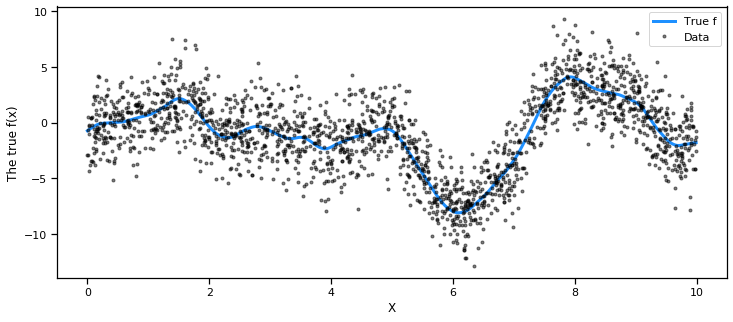

In [9]:
# set the seed
np.random.seed(1)

n = 2000 # The number of data points
X = 10*np.sort(np.random.rand(n))[:,None]

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(), 
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 2.0
y = f_true + σ_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, alpha=0.5, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("The true f(x)"); plt.legend();

We can specify a sparse marginal likelihood model via `MarginalSparse`, where the approximation method can be chosen. We will use the **fully independent training conditional (FITC)** algorithm to estimate the model, with the critical approximation being the imposition of a conditional independence assumption on the joint prior over training and test cases.

In [10]:
with pm.Model() as sparse_model:
    
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    
    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="FITC")

We next need a set of inducing points. We will initialize 20 inducing points with the **K-means** algorithm.

In [11]:
with sparse_model:
    
    Xu = pm.gp.util.kmeans_inducing_points(20, X)

From here, we use the `marginal_likelihood` method, just as we did with the full GP.

In [12]:
with sparse_model:
    
    σ = pm.HalfCauchy("σ", beta=5)
    obs = gp.marginal_likelihood("obs", X=X, Xu=Xu, y=y, noise=σ)
    
    trace = pm.sample(1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [σ, η, ℓ]
100%|██████████| 1500/1500 [00:42<00:00, 35.49it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [14]:
X_new = np.linspace(-1, 11, 200)[:,None]

# add the GP conditional to the model, given the new X values
with sparse_model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with sparse_model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=100)

100%|██████████| 100/100 [00:06<00:00, 14.80it/s]


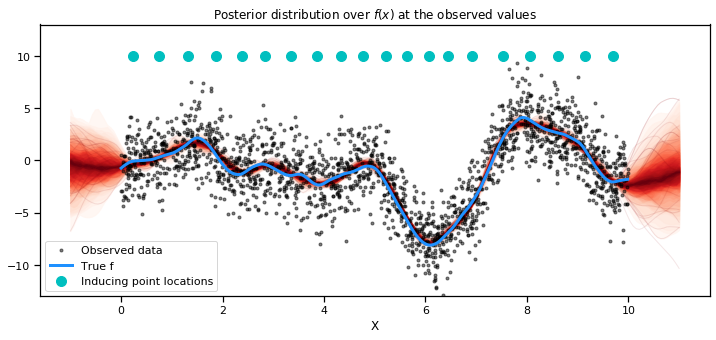

In [15]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], X_new);

# plot the data and the true latent function
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(Xu, 10*np.ones(Xu.shape[0]), "co", ms=10, label="Inducing point locations")

# axis labels and title
plt.xlabel("X"); plt.ylim([-13,13]);
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

### Multidimensional GP

Until now, our examples have been of 1-dimensional Gaussian processes, where there is just a single predictor variable thought to have a non-linear relationship to the outcome. Let's look at a real-world dataset that involves two predictors. We will use the famous **Walker Lake dataset (Isaaks & Srivistava 1989)** that involves spatial sampling of minerals and other variables over space. The data consist of two spatial coordinates and three measured outcomes. The outcomes are anonymously labeled as U, V (continuous variables, such as concentrarion) and T (discrete variable, such as the presence of a particular element). 

In [16]:
walker_data = pd.read_table('../data/walker.txt', sep='\s+', index_col=0, skiprows=8, header=None, 
              names=['ID', 'Xloc', 'Yloc', 'V', 'U', 'T'])
walker_data.head()

,Xloc,Yloc,V,U,T
ID,,,,,
1,11,8,0.0,1.000000e+31,2
2,8,30,0.0,1.000000e+31,2
3,9,48,224.4,1.000000e+31,2
4,8,69,434.4,1.000000e+31,2
5,9,90,412.1,1.000000e+31,2


The samples are taken regularly over a coarse grid across the entire area, and then irregularly over portions of the area, presumably where there were positive samples on the coarser grid. 

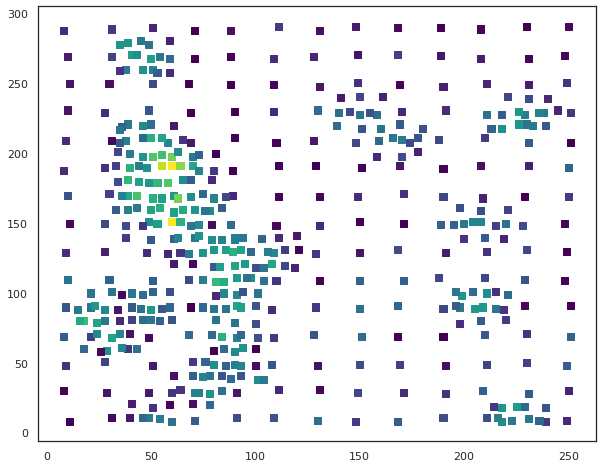

In [17]:
nx = 40
x1, x2 = np.meshgrid(np.linspace(0,300,nx), np.linspace(0,300,nx))
X = np.concatenate([x1.reshape(nx*nx, 1), x2.reshape(nx*nx, 1)], 1)

X_obs = walker_data[['Xloc', 'Yloc']].values
y_obs = walker_data.V.values

with sns.axes_style("white"):
    plt.figure(figsize=(10,8))
    plt.scatter(X_obs[:,0], X_obs[:,1], s=50, c=y_obs, marker='s', cmap=plt.cm.viridis);

We need a grid to predict on, as well as a sparser grid of inducing points:

In [18]:
nd = 30
z1, z2 = np.meshgrid(np.linspace(0, 300, nd), np.linspace(0, 300, nd))
Z = np.concatenate([z1.reshape(nd*nd, 1), z2.reshape(nd*nd, 1)], 1)

nd = 15
xu1, xu2 = np.meshgrid(np.linspace(0, 300, nd), np.linspace(0, 300, nd))
Xu = np.concatenate([xu1.reshape(nd*nd, 1), xu2.reshape(nd*nd, 1)], 1)

In [19]:
with pm.Model() as spatial_model:
    
    l = pm.HalfCauchy("l", beta=3, shape=(2,))
    sf2 = pm.HalfCauchy("sf2", beta=3)
    sn2 = pm.HalfCauchy("sn2", beta=3)

    K = pm.gp.cov.ExpQuad(2, l) * sf2**2
    
    gp_spatial = pm.gp.MarginalSparse(cov_func=K, approx="FITC")
    obs = gp_spatial.marginal_likelihood("obs", X=X_obs, Xu=Xu, y=y_obs, noise=sn2)

    mp = pm.find_MAP()

/Users/cfonnesbeck/anaconda3/envs/bayes_course/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -3,304.5, ||grad|| = 0.037952: 100%|██████████| 45/45 [00:01<00:00, 39.91it/s]     


In [20]:
with spatial_model:

    f_pred = gp_spatial.conditional('f_pred', Z)
    
    samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=100)

100%|██████████| 100/100 [00:44<00:00,  2.25it/s]


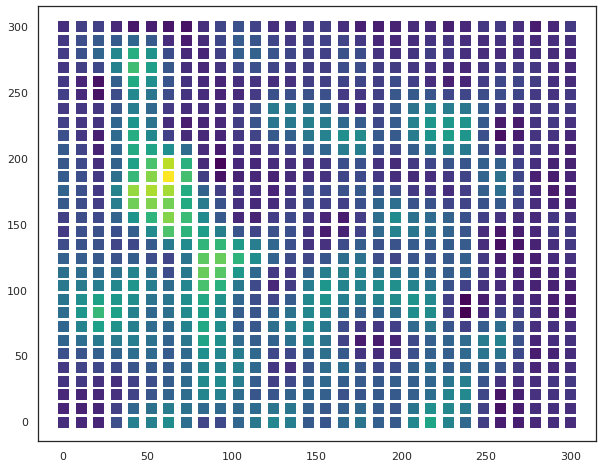

In [21]:
with sns.axes_style("white"):

    plt.figure(figsize=(10,8))
    plt.scatter(z1.flatten(), z2.flatten(), s=100, c=samples['f_pred'].mean(0), marker='s', cmap=plt.cm.viridis);

## Example: Nashville daily temperatures

The file `TNNASHVI.txt` in your data directory contains daily temperature readings for Nashville, courtesy of the [Average Daily Temperature Archive](http://academic.udayton.edu/kissock/http/Weather/). This data, as one would expect, oscillates annually. Use a Gaussian process to fit a regression model to this data.

In [55]:
daily_temps = pd.read_table("../data/TNNASHVI.txt", sep='\s+', 
                            names=['month','day','year','temp'], na_values=-99)

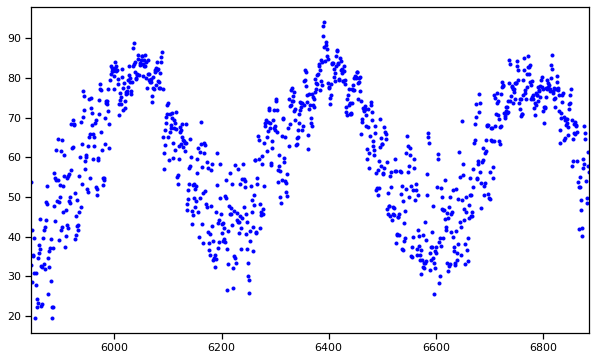

In [56]:
temps_2010 = daily_temps.temp[daily_temps.year>2010]
temps_2010.plot(style='b.', figsize=(10,6), grid=False)

In [57]:
x, y = temps_2010.reset_index().values.T
X = x.reshape(-1, 1)

In [58]:
# Write answer here

---
## References

[Rasmussen, C. E., & Williams, C. K. I. (2005). Gaussian Processes for Machine Learning (Adaptive Computation and Machine Learning series). The MIT Press.](http://www.amazon.com/books/dp/026218253X)

[Quinonero-Candela, J. & Rasmussen, C. E. (2005). A Unifying View of Sparse Approximate Gaussian Process Regression
Journal of Machine Learning Research 6, 1939–1959.](http://www.jmlr.org/papers/v6/quinonero-candela05a.html)

